# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


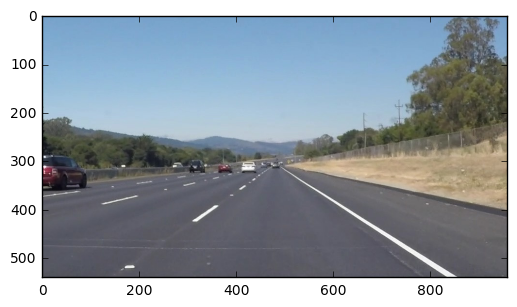

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def poly_line_f(points):
    """
    Given a course set of points return a function describing the best fit line.
    reference: http://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting
    """
    if len(points) == 0:
        return None
    
    points = np.array(points)
    # get x and y vectors
    x = points[:,0]
    y = points[:,1]

    # calculate polynomial
    z = np.polyfit(x, y, 1)
    f = np.poly1d(z)
    
    return f

def slope(x1, y1, x2, y2):
    return (y2-y1)/(x2-x1)

def y_intercept(x1, y1, m):
    return y1 - m * x1

def distance(x1, y1, x2, y2):
    return sqrt((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))
    
def enhanced_line(x1, y1, x2, y2, count=10, y_max=None):
    """
    Given a line defined by the points (x1, y1) and (x2, y2),
    enhance the line definition with additional points along the
    slope between those points.
    x1, y1: first point
    x2, y2: second point
    count: number of points to add
    y_max: if defined, also add a point at y_max along the same line
    """
    m = slope(x1, y1, x2, y2)
    b = y_intercept(x1, y1, m)
    points = []
    for sx in np.arange(x1, x2, (x2 - x1) / count):
        points.append((sx, m * sx + b))
    
    if y_max is not None and len(points) > 0:
        points.append((((y_max - b) / m), y_max))
    
    return points

def draw_lines_f(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws 'lines' on 'img', modifying 'img'.
    img: the image to draw on
    lines: the line segments to derive a single left and single right line from
    color: draw color
    thickness: line thickness
    """
    [h, w, d] = img.shape
    w_mid = w / 2 # center of image from left to right
    left_bin = [] # collect left side points
    right_bin = [] # collec right side points
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = slope(x1, y1, x2, y2)
            if m <= 0 and x1 <= w_mid and x2 <= w_mid and abs(m) > 0.5:
                left_bin.extend(enhanced_line(x1, y1, x2, y2, 10, y_max=h))
            elif x1 > w_mid and x2 > w_mid and abs(m) > 0.5:
                  right_bin.extend(enhanced_line(x1, y1, x2, y2, 10, y_max=h))
                
    # given set of points, define a best fit line for left and right lines
    left_line_f = poly_line_f(left_bin)
    right_line_f = poly_line_f(right_bin)
    
    # draw left line, spaning beyond image borders (we'll crop it later)
    if left_line_f is not None:
        left_bottom = (0, int(left_line_f(0)))
        left_top = (w, int(left_line_f(w)))
        cv2.line(img, left_bottom, left_top, color, thickness)
    
    # draw right line, spanning beyond image borders (we'll crop it later)
    if right_line_f is not None:
        right_bottom = (w, int(right_line_f(w)))
        right_top = (0, int(right_line_f(0)))
        cv2.line(img, right_bottom, right_top, color, thickness)
    
def hough_lines_f(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_f(line_img, lines, thickness=8)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'weighted_solidYellowCurve2.jpg',
 'weighted_solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'weighted_whiteCarLaneSwitch.jpg',
 'weighted_solidWhiteCurve.jpg',
 'weighted_solidWhiteRight.jpg',
 'weighted_solidYellowCurve.jpg',
 'solidWhiteCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

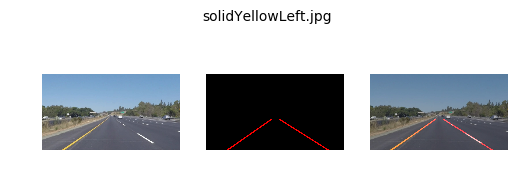

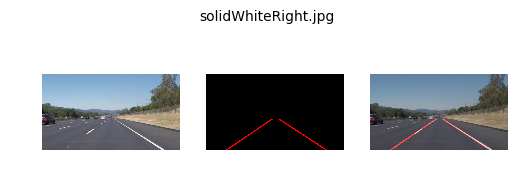

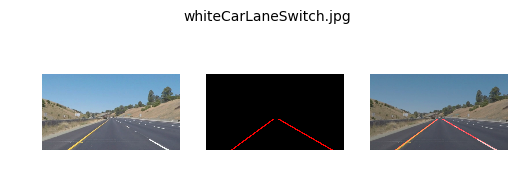

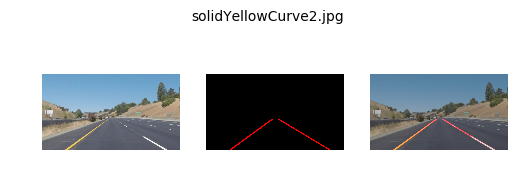

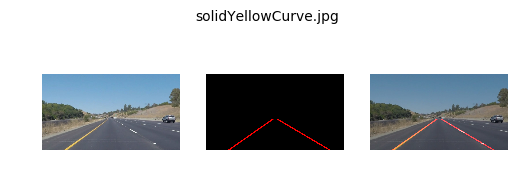

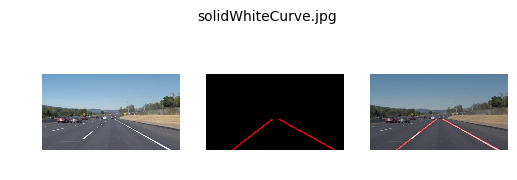

In [7]:


def simple_quad(h, w, h_div=0.6, bw_div=0.08, tw_div=0.46, w_shift_div=0.02):
    """
    Returns for vertices for symmetrical quadrilateral within the provided rectangle.
    h: rectangle height
    w: rectangle width
    h_div: percent of rectangle height to size quad height
    bw_div: percent of rectangle width to size quad bottom insets
    tw_div: percent of rectangle width to size quad top insets
    w_shift_div: percent of rectangle width to shift entire quad left or right from center
    
    Return: 4 vertices as an arry of one numpy array containing the 4 vertices
    """
    w_shift = w * w_shift_div # shift polygon distance if lanes not perfectly centered
    
    by = h # bottom y
    ty = h * h_div# top y
    ltx = w * tw_div + w_shift # left top x
    rtx = w - w * tw_div + w_shift # right top x
    lbx = w * bw_div + w_shift # left bottom x
    rbx = w - w * bw_div + w_shift # right bottom x
    return [np.array([[lbx, by], [ltx, ty], [rtx, ty], [rbx, by]], dtype=np.int32)]
    
def lane_finder_pipeline(img):
    """
    Find lane lines in an image.
    """
    [h, w, d] = img.shape
    result = img
    result = grayscale(result)
    result = canny(result, 200, 255)
    result = region_of_interest(result, simple_quad(h,w))
    result = hough_lines_f(result, 
                         rho=1, 
                         theta=np.pi/90, 
                         threshold=20, 
                         min_line_len=10, 
                         max_line_gap=40)
    result = region_of_interest(result, simple_quad(h,w, h_div=0.6, bw_div=0.01, tw_div=0.3, w_shift_div=0.02))
    
    return result

#
# process all images in the test_images directory
# we display the original image
# we draw lane lines with the pipeline and display
# we then draw the combined image
# the combined image is saved back to the test_images director, file name prefixed with 'weighted_"
#
images = os.listdir("test_images/")
i_plot = 0
for name in images:
    if name.startswith('weighted_'):
        continue
    i_plot += 1
    fig = plt.figure(i_plot)
    fig.suptitle(name)
    #reading in an image
    image = mpimg.imread('test_images/' + name)
    #printing out some stats and plotting
    plt.subplot(231)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(232)
    lanes = lane_finder_pipeline(image)
    plt.imshow(lanes, cmap='gray')
    plt.axis('off')
    plt.subplot(233)
    weighted = weighted_img(lanes, image)
    plt.imshow(weighted)
    plt.axis('off')
    cv2.imwrite('test_images/weighted_' + name, weighted)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [10]:
def process_image(image):
    # Finds lanes in image using pipeline and returns image with lines drawn on it
    # Return the final output (image with lines are drawn on lanes)

    return weighted_img(lane_finder_pipeline(image), image)

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'results/white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video results/white.mp4
[MoviePy] Writing video results/white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 25.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/white.mp4 

CPU times: user 2min 9s, sys: 4.06 s, total: 2min 13s
Wall time: 7.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'results/yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video results/yellow.mp4
[MoviePy] Writing video results/yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/yellow.mp4 

CPU times: user 6min 40s, sys: 13.3 s, total: 6min 53s
Wall time: 22.7 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### My Thoughts

The algorithm would be better if it kept a longer memory of where the lane lines were in previous frames and used that to influence the location of lines in the currently frame. This would help reduce the flicker observed when processing frames that are harder for the algorithm to process correclty.

The current algorithm will run into trouble in a few cases.

1. If there is a light colored car in front the camera, both because the light color will add unexpected points and lines and because it may obstruct the actual lane lines.
2. If there are more pronounced curves in the road.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'results/extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video results/extra.mp4
[MoviePy] Writing video results/extra.mp4


100%|██████████| 251/251 [00:15<00:00, 15.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/extra.mp4 

CPU times: user 4min 46s, sys: 9.28 s, total: 4min 56s
Wall time: 16.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))